In [0]:
!pip install tensorflow-gpu

In [0]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
dataset = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_data = dataset[0]
test_data = dataset[1]

In [40]:
train_images = train_data[0].astype('float32')/255.
train_images = train_images.reshape(-1 , 28 , 28 , 1)
train_labels = np.array(tf.keras.utils.to_categorical(train_data[1].astype('float32')))

print('Train Images : {}\nLabels : {}'.format(train_images.shape , train_labels.shape))

Train Images : (60000, 28, 28, 1)
Labels : (60000, 10)


Label - 5


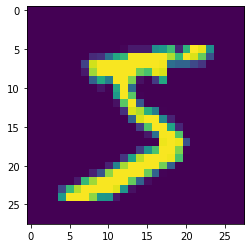

In [7]:
i = 0
plt.imshow(train_images[i])
print('Label - {}'.format(train_labels[i]))

#**Capsule Network for MNIST**

In [0]:
inp_tensor = tf.keras.Input(shape=(28,28,1) , dtype=tf.float32 , name="input_tensor")

In [9]:
tf.shape(inp_tensor)[0]

<tf.Tensor 'strided_slice:0' shape=() dtype=int32>

In [0]:
conv1 = tf.keras.layers.Conv2D(256 , (9,9) , activation = 'relu' , padding = 'valid')(inp_tensor)
conv2 = tf.keras.layers.Conv2D(256 , (9,9) , strides = 2 , padding = 'valid' , activation='relu')(conv1)

In [0]:
capsule1_n_caps = 6*6*32
capsule1_n_dims = 8

In [0]:
capsule1_raw = tf.keras.layers.Reshape((capsule1_n_caps , capsule1_n_dims))(conv2)

In [13]:
capsule1_raw.shape

TensorShape([None, 1152, 8])

In [0]:
def squash(inputs , axis=-1):
  sq_norm = tf.keras.backend.sum(tf.keras.backend.square(inputs) , axis=axis , keepdims=True)
  return ((sq_norm/(1. + sq_norm))/(tf.keras.backend.sqrt(sq_norm + tf.keras.backend.epsilon())))*inputs

In [0]:
capsule1_out = tf.keras.layers.Lambda(squash)(capsule1_raw)

In [16]:
capsule1_out.shape

TensorShape([None, 1152, 8])

In [0]:
capsule2_n_caps = 10
capsule2_n_dims = 16

In [0]:
def condition(counter , capsule_prediction , raw_weights , capsule2_output_pred):
  return tf.less(counter , 2)

In [0]:
def loop_body(counter , capsule_prediction , raw_weights , capsule2_output_pred):
  routing_weights = tf.nn.softmax(raw_weights , axis=2 , name='routing_weights')
  weighted_predictions = tf.multiply(routing_weights , capsule_prediction)
  weighted_sum = tf.reduce_sum(weighted_predictions , axis=1 , keepdims=True)
  capsule2_output = squash(weighted_sum , axis=-2)
  capsule2_output_tiled = tf.tile(capsule2_output , [1 , capsule1_n_caps , 1 , 1 , 1])
  agreement = tf.matmul(capsule_prediction , capsule2_output_tiled , transpose_a=True , name='agreement')
  raw_weights = tf.add(raw_weights , agreement)
  return tf.add(counter , 1) , capsule_prediction , raw_weights , capsule2_output

In [0]:
class CapsuleLayer(tf.keras.layers.Layer):
  def __init__(self , **kwargs):
    super(CapsuleLayer , self).__init__(**kwargs)
    self.kernel_initializer = tf.keras.initializers.get('glorot_uniform')

  def build(self , inp_tensor):
    self.init_sigma = 0.1
    self.W_init = tf.random.normal(shape=(1 , capsule1_n_caps , capsule2_n_caps , capsule2_n_dims , 8) , stddev=self.init_sigma)
    self.W = tf.Variable(self.W_init , name="W")
    # self.W = self.add_weight(shape = [10 , 6*6*32 , 16 , 8] , initializer = self.kernel_initializer , name = 'caps_weights')
    self.built = True

  def call(self , inputs):
    batch_size = tf.shape(inputs)[0]
    W_tiled = tf.tile(self.W , [batch_size , 1 , 1 , 1 , 1] , name='W_tiled')
    capsule1_out_exp = tf.expand_dims(inputs , -1 , name='capsule1_out_exp')
    capsule1_out_tile = tf.expand_dims(capsule1_out_exp , 2 , name='capsule1_out_tile')
    capsule1_out_tiled = tf.tile(capsule1_out_tile , [1 , 1 , capsule2_n_caps , 1 , 1] , name='capsule1_out_tiled')
    
    capsule2_pred = tf.matmul(W_tiled , capsule1_out_tiled , name='capsule2_pred')

    #ROUTING ALGORITHM

    capsule2_output = tf.zeros(shape=(batch_size , 1 , 10 , 16 , 1))
    counter = tf.constant(0)
    b = tf.zeros([batch_size , capsule1_n_caps , capsule2_n_caps , 1 , 1] , name='b')
    _ , _ , _ , capsule2_output = tf.while_loop(condition , loop_body , [counter , capsule2_pred , b , capsule2_output] , swap_memory=True)

    return capsule2_output
    # inputs = tf.keras.backend.expand_dims(inputs , 1)
    # inputs = tf.keras.backend.tile(inputs , [1 , 10 , 1 , 1])
    # inputs = tf.keras.backend.map_fn(lambda x: tf.keras.backend.batch_dot(x , self.W , [2 , 3]) , elems=inputs)
    # b = tf.zeros(shape=[tf.keras.backend.shape(inputs)[0] , 10 , 6*6*32])

    # for

In [0]:
capsules = CapsuleLayer()(capsule1_out)

In [22]:
capsules

<tf.Tensor 'capsule_layer/Identity:0' shape=(None, 1, 10, 16, 1) dtype=float32>

In [0]:
def custom_norm(input , axis=-1 , epsilon=1e-7 , keep_dims=False):
  return tf.sqrt(tf.reduce_sum(tf.square(input) , axis=axis , keepdims=keep_dims) + epsilon)

In [0]:
output = tf.keras.layers.Lambda(custom_norm , arguments={'axis':-2})(capsules)

In [25]:
output.shape

TensorShape([None, 1, 10, 1])

In [26]:
y = tf.keras.Input(() , dtype=tf.int64)
y

<tf.Tensor 'input_1:0' shape=(None,) dtype=int64>

In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5
ALPHA = 0.0005

In [0]:
def mask_handler(outputs):
  capsule2_output = outputs[0]
  y_out = outputs[1]
  output_argmax = tf.argmax(output , axis=2)
  output_pred = tf.squeeze(output_argmax , axis=[1 , 2])

  mask_with_labels = tf.Variable(False , shape=() , name='mask_with_labels')
  reconstruction_targets = tf.cond(mask_with_labels , lambda: y_out , lambda: output_pred)
  reconstruction_mask = tf.one_hot(reconstruction_targets , depth=capsule2_n_caps)
  reconstruction_mask_reshaped = tf.reshape(reconstruction_mask , (-1 , 1 , capsule2_n_caps , 1 , 1))
  capsule2_output_masked = tf.multiply(capsule2_output , reconstruction_mask_reshaped)
  return tf.reshape(capsule2_output_masked , (-1 , capsule2_n_caps * capsule2_n_dims))

In [29]:
masked = tf.keras.layers.Lambda(mask_handler)([capsules , y])
masked

<tf.Tensor 'lambda_2/Identity:0' shape=(None, 160) dtype=float32>

In [30]:
decoder_input = tf.keras.Input((capsule2_n_caps * capsule2_n_dims , ))
decoder_outputs = tf.keras.layers.Dense(512 , activation='relu')(decoder_input)
decoder_outputs = tf.keras.layers.Dense(1024 , activation='relu')(decoder_outputs)
decoder_outputs = tf.keras.layers.Dense(28*28 , activation='sigmoid')(decoder_outputs)
decoder_outputs

<tf.Tensor 'dense_2/Identity:0' shape=(None, 784) dtype=float32>

In [0]:
def margin_loss_fx(y_true , y_pred):
  y_true = tf.one_hot(y_true , depth=capsule2_n_caps)
  capsule2_output_norm = custom_norm(y_pred , axis=-2 , keep_dims=True)
  present_error_raw = tf.square(tf.maximum(0. , m_plus - capsule2_output_norm))
  present_error = tf.reshape(present_error_raw , shape=(-1 , 10))
  absent_error_raw = tf.square(tf.maximum(0. , capsule2_output_norm - m_minus))
  absent_error = tf.reshape(absent_error_raw , shape=(-1 , 10))

  L = tf.add(y_true * present_error , lambda_ * (1.0 - y_true) * absent_error)
  return tf.reduce_mean(tf.reduce_sum(L , axis=1))

In [0]:
def reconstruction_loss_fx(x_train , decoder_outputs):
  x_flat = tf.reshape(x_train , [-1 , 28*28])
  return tf.reduce_mean(tf.square(x_flat - decoder_outputs))

In [0]:
def loss_fx(y_true , y_pred):
  return tf.add(margin_loss_fx(y_true[0] , y_pred[0]) , ALPHA * reconstruction_loss_fx(y_true[1] , y_pred[1]))

In [0]:
decoder = tf.keras.Model(decoder_input , decoder_outputs)
model = tf.keras.Model([inp_tensor , y] , [output , decoder(masked)])

In [36]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tensor (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 256)  20992       input_tensor[0][0]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 6, 6, 256)    5308672     conv2d[0][0]                     
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1152, 8)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [44]:
tester = tf.expand_dims(train_images[0] , axis=0)
tester.shape

TensorShape([1, 28, 28, 1])

Prediction Test
Label Shape : (1, 1, 10, 1)	Decoder output Shape : (1, 784)



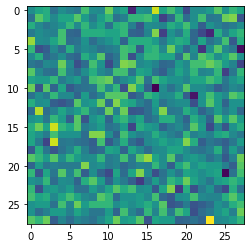

In [50]:
test_label_pred , test_decoded_pred = model.predict([tester , train_labels[0]])
print("Prediction Test\nLabel Shape : {}\tDecoder output Shape : {}\n".format(test_label_pred.shape , test_decoded_pred.shape))

test_decoded_pred = test_decoded_pred.reshape((28 , 28))
plt.imshow(test_decoded_pred)